In [1]:
import os 
import tarfile
import pandas as pd
import numpy as np
from six.moves import urllib
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# fetch the data. It is extremely useful because I need to install the dataset on multiple machines.

In [3]:
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml/master/'
HOUSING_PATH = os.path.join('datasets', 'housing')
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz'

In [4]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()


In [5]:
fetch_housing_data()

In [6]:
# load the data

In [7]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [8]:
housing = load_housing_data()

In [9]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [10]:
# quick look at the data structure

In [11]:
housing.info() # useful code

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [12]:
housing['ocean_proximity'].value_counts() # useful code

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [13]:
housing.describe() # useful code

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Notice 
* there are NULLs in the data 

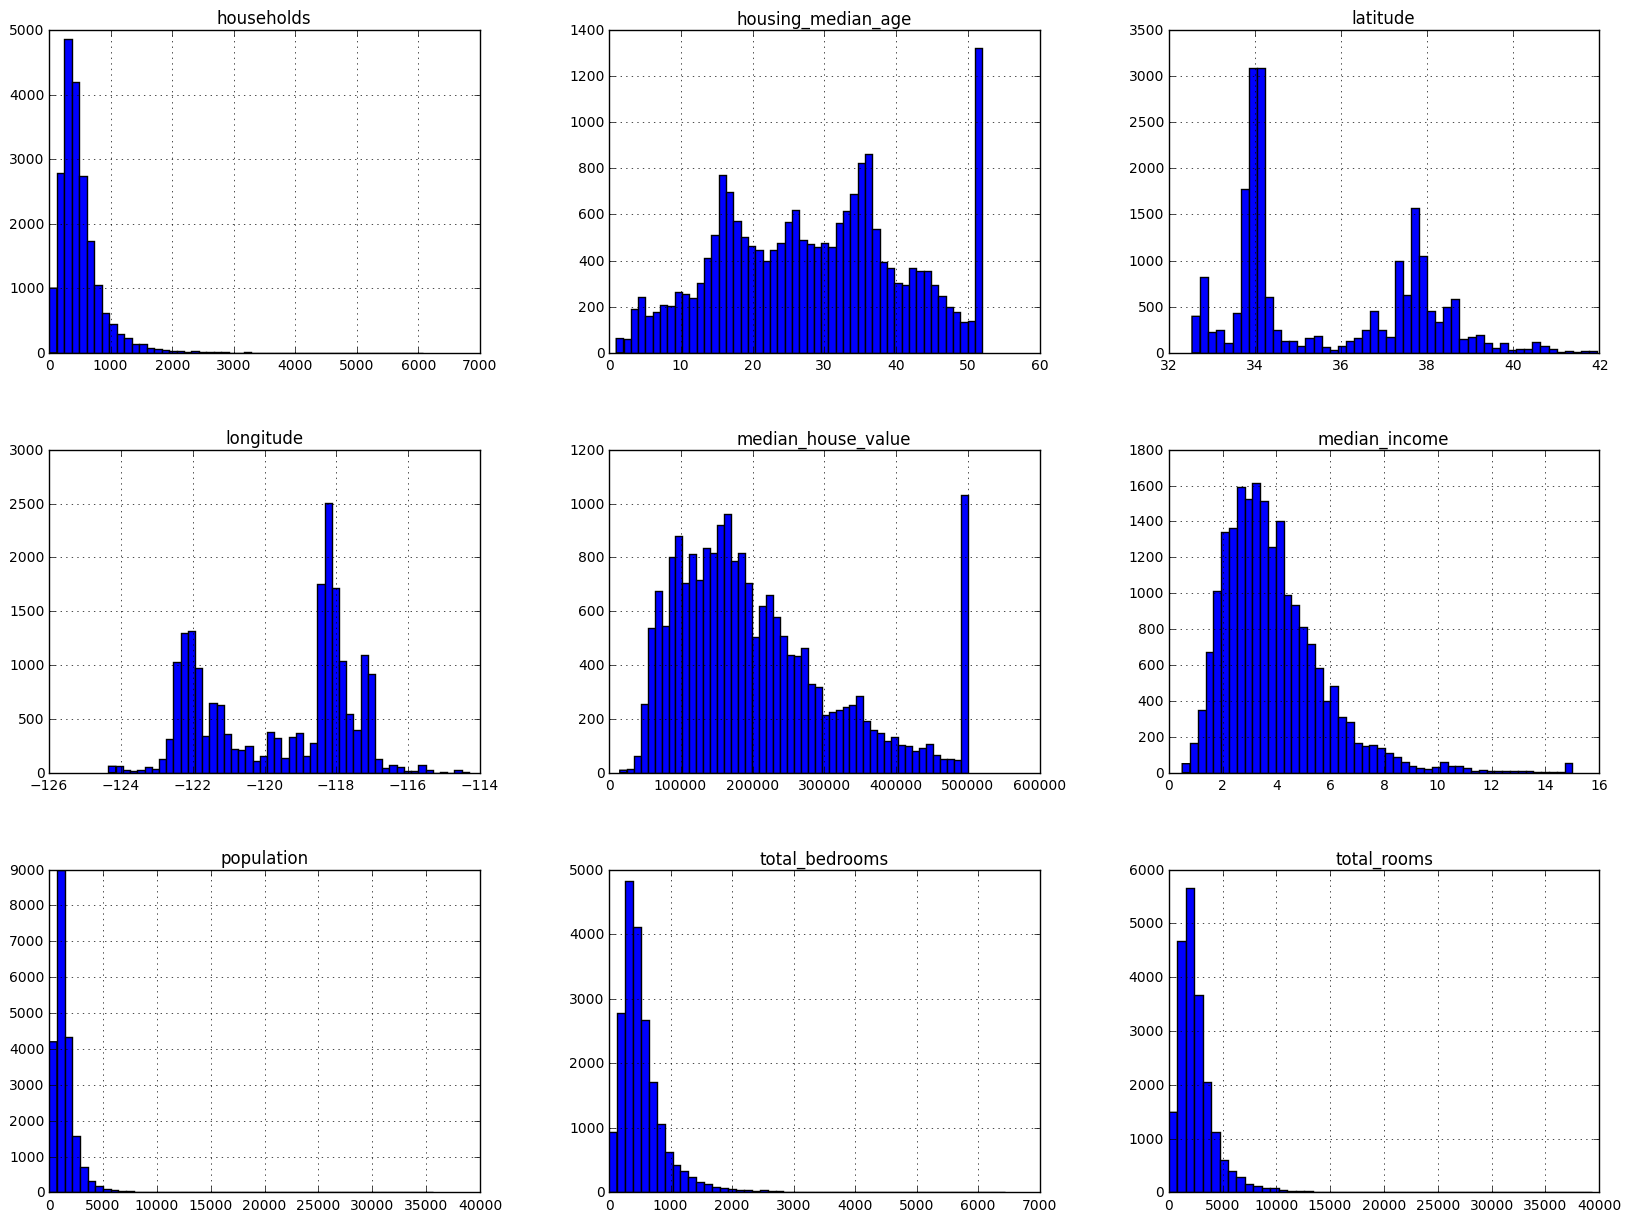

In [14]:
#housing['median_income'].hist()
housing.hist(bins=50, figsize=(20,15))
plt.show()

Notice 
* units of x-axle: median_income is pre-categorized; 
* min and max capped: house_median_age, median_house_value are capped. 
* tail heavy: the histoograms extend much farther to the righ of the median than to the left. 

# Diferent methods to create test set

In [15]:
# a not good solution!
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data)) #shake up
    test_set_size = int(len(data) * test_ratio) 
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [16]:
train_set, test_set = split_train_test(housing, 0.2)

In [17]:
print(len(train_set), len(test_set))

(16512, 4128)


Note

The method above to set up test_set is not good. Everytime it will generate a random/different test set (as well as train set). So after running many times, the model itself will eventually experienced whole dataset already. I made this mistake in training dwell time model. :( 
* solution: use hash

In [18]:
len(housing)

20640

In [19]:
# a better solution!
import hashlib
# creat hash from unique identifier 
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio
# create test, train dataset from hash 
def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

Question: what is hash? how compute a hash out of each instances' identifier? does identifier need to be unique? why? 

In [20]:
housing_with_id = housing.reset_index()
# longitude and latitude could generate the unique identifer 
housing_with_id['id'] = housing['longitude']*1000 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')

# sklearn

In [21]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.19.0.


In [22]:
# same methodology as above (hash), you can do in Sklearn quickly
from sklearn.model_selection import train_test_split 
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

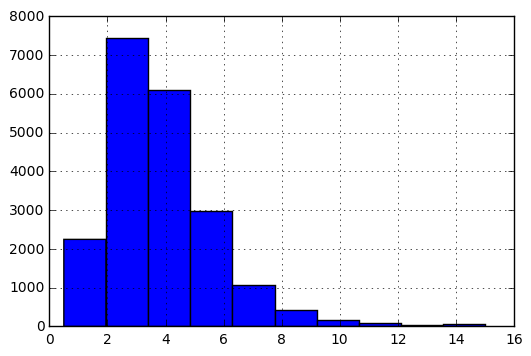

In [23]:
housing['median_income'].hist()

# Goal: strategic sampling

I want to make sure test set is representative of the whole income population. (income is very importation for housing price). So, it is important to have sufficient number of data for each stratum 
* can't have too many stratum
* each stratum is large enough


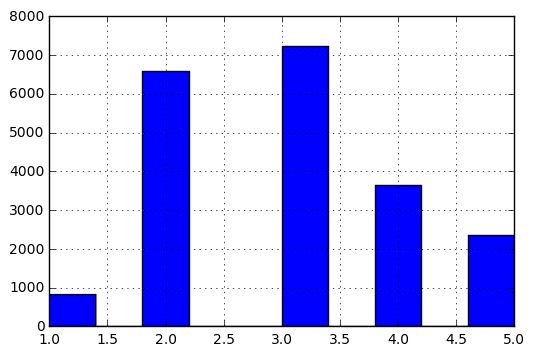

In [24]:
# create new stratums
housing['income_cat'] = np.ceil(housing['median_income']/1.5) #ceiling is for round up 
housing['income_cat'].where(housing['income_cat']<5, 5.0, inplace=True)
housing['income_cat'].hist()

In [25]:
# stratify sampling for test set
from sklearn.model_selection import StratifiedShuffleSplit

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html

In [26]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 
#n_split: Number of re-shuffling; random_state: seed for random number generator
for train_index, test_index in sss.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [27]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

Remove the income_cat attribute, so the data is back to its original state

In [28]:
for set_ in(strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Exploring the Data: Discover and Visulization

In [29]:
housing = strat_train_set.copy()

c:\anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


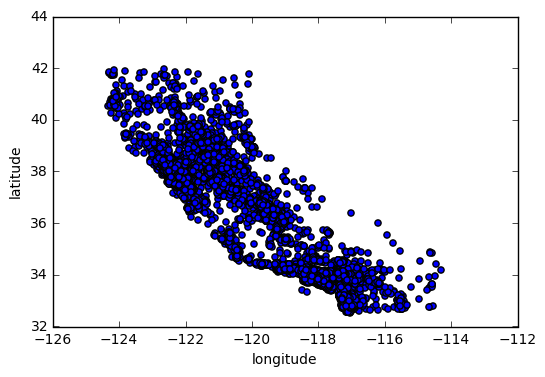

In [30]:
housing.plot(kind="scatter", x='longitude', y='latitude')

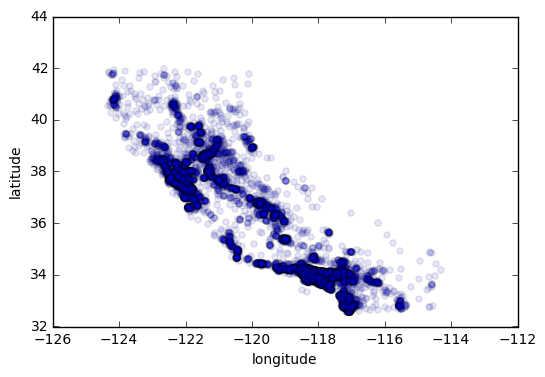

In [31]:
housing.plot(kind="scatter", x='longitude', y='latitude', alpha=0.1) 
#alpha: help to see the density area

Notice: 

high density areas: Bay area, LA, SD, Sacramento, Fresno (fresno! ohooo)

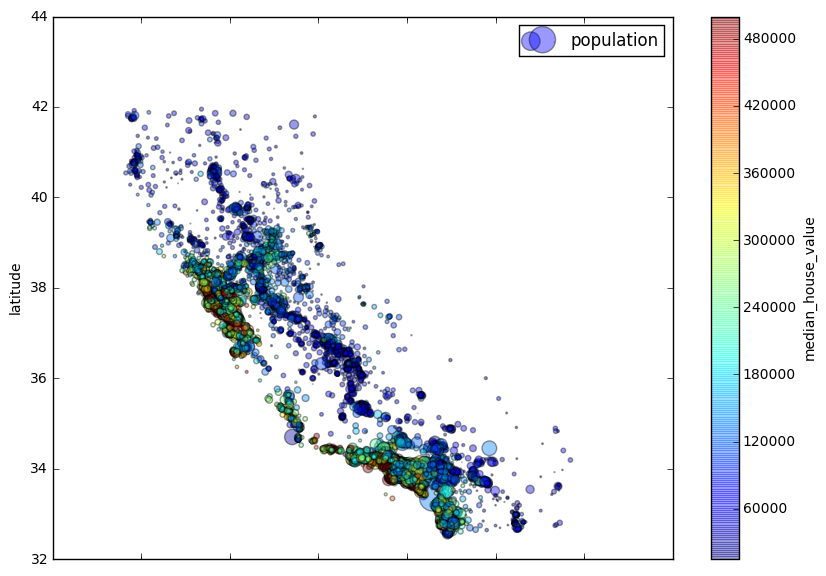

In [32]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
            s=housing['population']/100, label='population', figsize=(10,7), 
             #s: the radius of each circle represents the population density
            c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True
             #c: color represents the price
            ) 
plt.legend()

In [33]:
corr_matrix = housing.corr()

In [34]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

In [35]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']

In [36]:
from pandas.plotting import scatter_matrix

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.plotting.scatter_matrix.html

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000B58F780>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000AD9BB70>]], dtype=object)

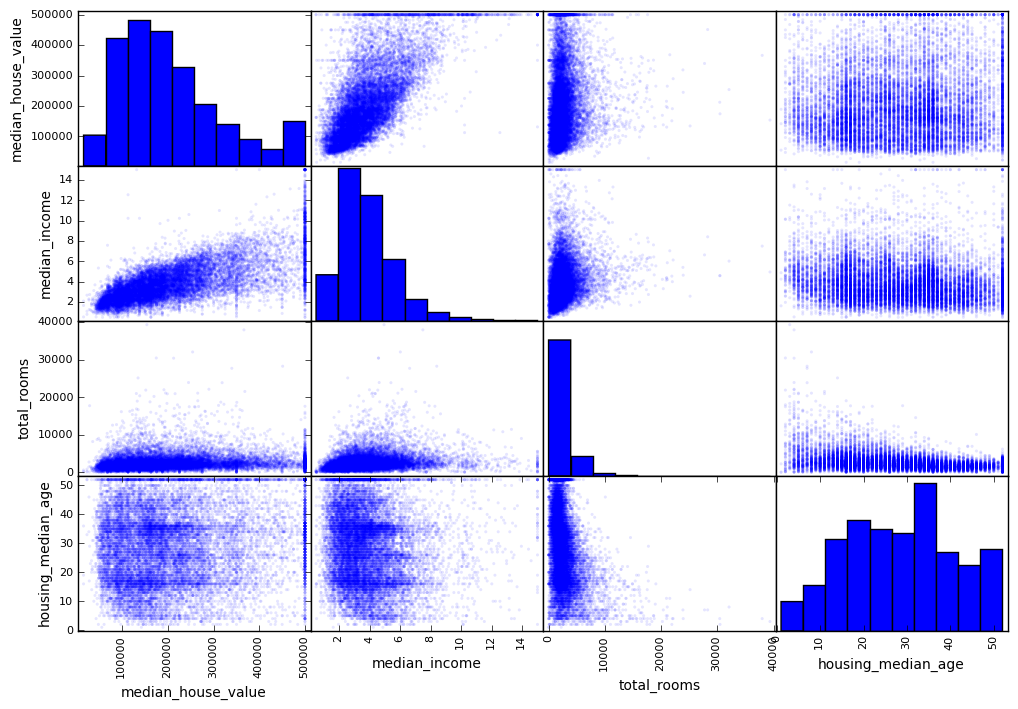

In [37]:
scatter_matrix(housing[attributes], alpha=0.1, figsize=(12, 8))

In [38]:
# sometimes data combination will help detect the corrilation
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['population_per_household'] = housing['population']/housing['households'] 

In [39]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
Name: median_house_value, dtype: float64

# prepare data for ML algorithms
(AKA: Data cleaning)

Handle missing data
1. get rid of the corresponding districts/features/attributes/rows
2. set the value to the missing data (zero, median, mean, etc.)

In [40]:
# I chose to fill missing house value with median house value. 
housing = strat_train_set.drop('median_house_value', axis = 1)
housing_labels = strat_train_set['median_house_value'].copy()

In [41]:
# or you can do it in imputer 
from sklearn.preprocessing import Imputer 
imputer = Imputer(strategy='median') #telling imputer to go with median 

In [42]:
housing_num = housing.drop('ocean_proximity', axis = 1) 
#drop the column has text values, besucase imputer can only process integer 

In [43]:
imputer.fit(housing_num) #give imputer value 

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [44]:
imputer.statistics_ #you could see imputer's value from this function 

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [45]:
housing_num.median().values 

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [46]:
X = imputer.transform(housing_num) # use imputer to fill the missing data 
# X is an array 

In [47]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

Recategory

['ocean_proximity'] is a text column, so we want to transfer it to integer 

Most ML algorithms works with integer 

* solution 1: factorize

In [157]:
housing_cat = housing['ocean_proximity']
housing_cat.head()

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
Name: ocean_proximity, dtype: object

In [166]:
# pandas factorize() method maps each category to a different integer
housing_cat_encoded, housing_categories = housing_cat.factorize()

In [50]:
housing_cat_encoded[:20]

array([0, 0, 1, 2, 0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 3, 2, 2, 2], dtype=int64)

In [51]:
housing_categories

Index([u'<1H OCEAN', u'NEAR OCEAN', u'INLAND', u'NEAR BAY', u'ISLAND'], dtype='object')

* solution 2: OneHotEncoder (1-hot, 0-cold)

In [52]:
# OneHotEncoder could convert integer value into one-hot vector

In [158]:
from sklearn.preprocessing import OneHotEncoder

In [160]:
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))


In [150]:
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

* solution 3: CategoricalEncoder

In [58]:
# CategoricalEncoder <-- encoder text value + transfer integer to binary boolean
#from sklearn.preprocessing import CategoricalEncoder
'''
The CategoricalEncoder class is only available at SKlearn 0.20.0 and later, 
I am using 0.19.0 version now. 
So solution here is - copied pasted the future_encoder.py file from ageron/handson-ml repository,
this python file gives me the same function as CategoricalEncoder. 
'''
#I copied pasted the future_encoder.py file from ageron/handson-ml repository
from  future_encoders  import OrdinalEncoder 

In [59]:
cat_encoder = OrdinalEncoder()
housing_cat_reshaped = housing_cat.values.reshape(-1, 1)
housing_cat_reshaped

array([['<1H OCEAN'],
       ['<1H OCEAN'],
       ['NEAR OCEAN'],
       ..., 
       ['INLAND'],
       ['<1H OCEAN'],
       ['NEAR BAY']], dtype=object)

In [60]:
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

array([[ 0.],
       [ 0.],
       [ 4.],
       ..., 
       [ 1.],
       [ 0.],
       [ 3.]])

# Customer Transformers

In [61]:
from sklearn.base import BaseEstimator, TransformerMixin

In [70]:
# the class is to creat extra attributes by combining your attributes
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room: 
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,bedrooms_per_room]
        else: 
            return np.c_[X, rooms_per_household, population_per_household]

In [71]:
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [189]:
# this class is to select integer attributes from your dataframe
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names 
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [106]:
num_attribs = list(housing_num)
selector = DataFrameSelector(num_attribs)
housing_num_attribs = selector.transform(housing)

In [184]:
# this class is to select specific text-based attributes from your dataframe
class DataFrameSelector2(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names 
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values.reshape(-1, 1) #here: have to put a reshape function

In [111]:
housing.head(1)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN


In [109]:
housing_num_attribs[:1]

array([[ -121.89  ,    37.29  ,    38.    ,  1568.    ,   351.    ,
          710.    ,   339.    ,     2.7042]])

# Feature Scaling

MinMaxScaler
http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler
bound values to a specific range

X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

X_scaled = X_std * (max - min) + min

StandardScaler http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
standardization - first substract the mean value, then it divides by the variance so that the resulting distribution has unit variance. 

In [78]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

In [79]:
test = housing_num

In [85]:
test = imputer.fit_transform(test)

In [86]:
std_scaler.fit_transform(test)

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.63621141,
        -0.42069842, -0.61493744],
       [-1.17602483,  0.6596948 , -1.1653172 , ..., -0.99833135,
        -1.02222705,  1.33645936],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.43363936,
        -0.0933178 , -0.5320456 ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.60790363,
         0.71315642, -0.3167053 ],
       [ 0.78221312, -0.85106801,  0.18664186, ..., -0.05717804,
        -0.37545069,  0.09812139],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.13515931,
         0.3777909 , -0.15779865]])

# Pipeline

In [72]:
from sklearn.pipeline import Pipeline

In [73]:
from sklearn.preprocessing import StandardScaler 

* the pipeline name couldn't contain double underscores "__"

In [112]:
num_pipeline = Pipeline ([
    ('imputer', Imputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [136]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [185]:
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector2(cat_attribs)),
    ('cat_encoder', OneHotEncoder()),
])

In [186]:
#combine multiple pipelines 
from sklearn.pipeline import FeatureUnion

In [187]:
full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

In [188]:
housing_prepared = full_pipeline.fit_transform(housing)

In [172]:
from future_encoders import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat.values.reshape(-1, 1))
housing_cat_1hot

<16512x5 sparse matrix of type '<type 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>